In [12]:
# import libraries needed
import pandas as pd
import numpy as np
import random

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit.Chem import Descriptors

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

Import cleaned and standardized data for the Tox21 NR-AhR assay.  Use train and score datasets as train and test data, respectively.

In [3]:
train = pd.read_csv('../processed_data/nr_ahr_std_train.csv')
#train.head()

train_data = train.std_compounds
train_labels = train.label

print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)

active_train = train_data[train_labels == 1].reset_index(drop=True)
inactive_train = train_data[train_labels == 0].reset_index(drop=True)

print('Active compounds:', len(train_labels[train_labels == 1]))
print('Inactive compounds:', len(train_labels[train_labels == 0]))
print('Inactive : Active ~', len(train_labels[train_labels == 0]) // len(train_labels[train_labels == 1]))

Train data shape: (6709,)
Train labels shape: (6709,)
Active compounds: 761
Inactive compounds: 5948
Inactive : Active ~ 7


In [4]:
test = pd.read_csv('../processed_data/nr_ahr_test_std.csv')
#test.head()

test_data = test.std_compounds
test_labels = test.label

print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)

print('Active compounds:', len(test_labels[test_labels == 1]))
print('Inactive compounds:', len(test_labels[test_labels == 0]))
print('Inactive : Active ~', len(test_labels[test_labels == 0]) // len(test_labels[test_labels == 1]))

Test data shape: (607,)
Test labels shape: (607,)
Active compounds: 71
Inactive compounds: 536
Inactive : Active ~ 7


## Conventional features used in chemistry ML using RDKit

Following a kaggle tutorial:  https://www.kaggle.com/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec

### Morgan fingerprinting (ECFP)

Reference link: https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md

Notes:
- Need to convert SMILES strings to RDKit Mol object first
- Uses mol2vec to create molecular "sentences" that are then translated to vector representations of the substructures (based on word2vec)
- **Warning**: mol2vec is dependent on an old version (3.8.0) of Gensim to work.  It would not work with Gensim 4.0.0.

In [10]:
def ecfp_featurizer(train, test):
    
    # convert SMILES to RDKit Mol object
    train['mol'] = train['std_compounds'].apply(lambda x: Chem.MolFromSmiles(x))
    test['mol'] = test['std_compounds'].apply(lambda x: Chem.MolFromSmiles(x))
    
    model = word2vec.Word2Vec.load('model_300dim.pkl')
    
    #Constructing sentences
    train['sentence'] = train.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
    test['sentence'] = test.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

    # extracting embeddings to a numpy.array
    # note that we always should mark unseen='UNK' in sentence2vec() 
    # so that model is taught how to handle unknown substructures
    train['mol2vec'] = [DfVec(x) for x in sentences2vec(train['sentence'], model, unseen='UNK')]
    test['mol2vec'] = [DfVec(x) for x in sentences2vec(test['sentence'], model, unseen='UNK')]
    x_train = np.array([x.vec for x in train['mol2vec']])
    x_test = np.array([x.vec for x in test['mol2vec']])
    
    return x_train, x_test

In [11]:
x_ecfp, x_ecfp_test = ecfp_featurizer(train, test)

print(x_ecfp.shape)
print(x_ecfp_test.shape)

(6709, 100)
(607, 100)


### 1D representation of molecules using RDKit

Includes two types of features: 
- Atom counts - total number of atoms; number of heavy atoms; number of C, O, N, Cl atoms
- Molecular descriptors - molecular weight, number of valence electrons, number of heteroatoms

In [13]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

In [22]:
def oned_featurizer(train, test):
    
    # convert SMILES to RDKit Mol object
    train['mol'] = train['std_compounds'].apply(lambda x: Chem.MolFromSmiles(x))
    test['mol'] = test['std_compounds'].apply(lambda x: Chem.MolFromSmiles(x))
    
    # number of atoms
    train['mol'] = train['mol'].apply(lambda x: Chem.AddHs(x))
    train['num_of_atoms'] = train['mol'].apply(lambda x: x.GetNumAtoms())
    train['num_of_heavy_atoms'] = train['mol'].apply(lambda x: x.GetNumHeavyAtoms())
    number_of_atoms(['C','O', 'N', 'Cl'], train)
    
    test['mol'] = test['mol'].apply(lambda x: Chem.AddHs(x))
    test['num_of_atoms'] = test['mol'].apply(lambda x: x.GetNumAtoms())
    test['num_of_heavy_atoms'] = train['mol'].apply(lambda x: x.GetNumHeavyAtoms())
    number_of_atoms(['C','O', 'N', 'Cl'], test)
    
    # molecular descriptors
    train['mol_w'] = train['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
    train['num_valence_electrons'] = train['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
    train['num_heteroatoms'] = train['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
    
    test['mol_w'] = test['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
    test['num_valence_electrons'] = test['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
    test['num_heteroatoms'] = test['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))
    
    x_train = train[['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms', 
                     'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'mol_w', 
                     'num_valence_electrons', 'num_heteroatoms']]
    x_test = test[['num_of_atoms', 'num_of_heavy_atoms', 'num_of_C_atoms', 
                     'num_of_O_atoms', 'num_of_N_atoms', 'num_of_Cl_atoms', 'mol_w', 
                     'num_valence_electrons', 'num_heteroatoms']]
    
    return x_train, x_test

In [23]:
x_oned, x_oned_test = oned_featurizer(train, test)

print(x_oned.shape)
print(x_oned_test.shape)

(6709, 9)
(607, 9)


### Run some models

In [25]:
def run_model(classifier, classifier_name, x_train, x_test):
    """Helper function for running and evaluating models"""
    
    trained_classifier = classifier.fit(x_train, train_labels)
    
    # print classification report for model 
    report = classification_report(test_labels, trained_classifier.predict(x_test))
    print(report)
    
    # print roc-auc score for model
    roc_auc = roc_auc_score(test_labels, trained_classifier.predict_proba(x_test)[:, 1])
    print(f'ROC-AUC: {roc_auc:.3f}')
    
    # show a confusion matrix for the model
    disp = plot_confusion_matrix(trained_classifier, x_test, test_labels, cmap='cividis')
    disp.figure_.suptitle(f'Confusion Matrix for {classifier_name} Model')
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.65      0.78       536
           1       0.25      0.89      0.39        71

    accuracy                           0.68       607
   macro avg       0.61      0.77      0.59       607
weighted avg       0.89      0.68      0.74       607

ROC-AUC: 0.852


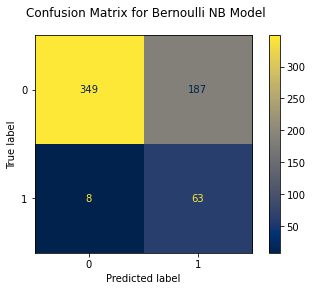

In [26]:
classifier = BernoulliNB()
run_model(classifier, 'Bernoulli NB', x_ecfp, x_ecfp_test)

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       536
           1       0.31      0.14      0.19        71

    accuracy                           0.86       607
   macro avg       0.60      0.55      0.56       607
weighted avg       0.83      0.86      0.84       607

ROC-AUC: 0.693


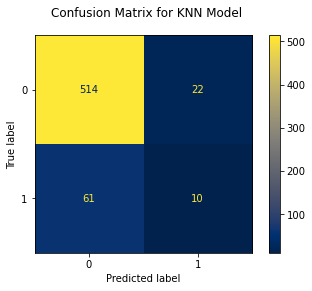

In [29]:
classifier = KNeighborsClassifier(n_neighbors=10)
run_model(classifier, 'KNN', x_oned, x_oned_test)